&#x1F516;Reference

https://www.waxworksmath.com/Authors/G_M/Kuhn/kuhn.html

http://www.ituring.com.cn/article/215742

\begin{exercise}

\end{exercise}
- (a) Given the classification imbalance in hepatic injury status, describe how you would create a training and testing set 
- (b) Which classification statistic would you choose to optimize for this exercise and why?
- (c) Split the data into a training and a testing set, pre-process the data, and build models described in this chapter for the biological predictors and separately for the chemical fingerprint predictors. Which model has the best predictive ability for the biological predictors and what is the optimal performance? Which model has the best predictive ability for the chemical predictors and what is the optimal performance? Based on these results, which set of predictors contains the most information about hepatic toxicity?
- (d) For the optimal models for both the biological and chemical predictors, what are the top five important predictors?
- (e) Now combine the biological and chemical fingerprint predictors into one predictor set. Retrain the same set of predictive models you built from part (c). Which model yields best predictive performance? Is the model performance better than either of the best models from part (c)? What are the top five important predictors for the optimal model? How do these compare with the optimal predictors from each individual predictor set?
- (f) Which model (either model of individual biology or chemical fingerprints or the combined predictor model), if any, would you recommend using to predict compounds’ hepatic toxicity? Explain.

In [1]:
library(AppliedPredictiveModeling)
data(hepatic)
dim(bio);dim(chem);
str(injury)

[1] 281 184

[1] 281 192

 Factor w/ 3 levels "Mild","None",..: 1 2 2 3 1 3 2 2 2 2 ...


In [2]:
prop.table(table(injury))

injury
     Mild      None    Severe 
0.5160142 0.3772242 0.1067616 

\begin{remark}
(a) Given the classification imbalance in hepatic injury status, describe how you would create a training and testing set
\end{remark}

In [3]:
any_damage <- as.character(injury)
any_damage[any_damage=="Mild"] = "Yes"
any_damage[any_damage=="Severe"] = "Yes"
any_damage[any_damage=="None"] = "No"
any_damage = factor( any_damage, levels=c("Yes","No") )
prop.table(table(as.data.frame(any_damage)))


      Yes        No 
0.6227758 0.3772242 

In [4]:
#use createDataPartition apply stratified sampling 
library(caret)
trn_id <- createDataPartition(any_damage,p=0.8,list = F)
prop.table(table(as.data.frame(any_damage[trn_id])))
prop.table(table(as.data.frame(any_damage[-trn_id])))

Loading required package: lattice
Loading required package: ggplot2



      Yes        No 
0.6222222 0.3777778 


  Yes    No 
0.625 0.375 

> A data set from the pharmaceutical industry was used to develop a model for predicting compounds probability of causing hepatic injury.

><font color=#3b5998>**Aurelien Geron (2017)**</font> Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner). 


In this case I care more about `recall` $\frac{TP}{TP+FN}$ , because we don't want use compounds which will indeed lead to hepatic injury. We have to capture those compounds mixtures as much as possible. 

&#x1F52C; `Use the biological predictors`

In [149]:
# #my function of std_PreProcess TBD
std_pre_process = function(df){
    #missing value
    #
    na_info <- any(is.null(df))
    if(na_info){
        na_col <- unlist(lapply(df),function(x) any(is.na(x)))
        print( "Columns with missing value")
        names(na_col)[na_col]
    }else{
        print("There is no missing value.")
    }
    #Near Zero-Variance Predictors
    # 
    nzv_info <- length(nearZeroVar(df))
    if(nzv_info!=0){
        print( "Columns with missing value")
        print(nearZeroVar(df,names =T))
        df <- df[,-nearZeroVar(df)]
    }else{
        print("Thers is no Near Zero-Variance Predictor")
    }
                         
}

&#x25B6; `Missing Values`

In [8]:
any(is.null(bio))

# na_info <- any(is.null(bio))
# if(na_info){
#     na_col <- unlist(lapply(bio,function(x) any(is.na(x))))
#     names(na_col)[na_col]
# }else
#     {
#     cat("There is no missing value!")}

[1] FALSE

There is no missing value!

&#x25B6; `NearZero Var`

In [9]:
nzv_cols = nearZeroVar(bio)
head(colnames(bio)[nzv_cols])
bio_flt_nzv <- bio[,-nzv_cols]

[1] "Z2"  "Z3"  "Z5"  "Z8"  "Z9"  "Z13"

&#x25B6; `Linear Dependencies`

In [22]:
linear_cols <- findLinearCombos(bio_flt_nzv)
linear_cols

$linearCombos
list()

$remove
NULL

&#x25B6; `Skewness`

In [80]:
library(e1071)
skew_info  <- apply(bio_flt_nzv,2,skewness)
head(sort(skew_info,decreasing = T))
tail(sort(skew_info,decreasing = T))

Z147      Z17      Z85     Z125     Z145     Z132 
9.240995 8.602032 7.496439 5.840128 5.304804 4.979319

Z105      Z176      Z140      Z169      Z144      Z146 
-5.947533 -6.482465 -7.885383 -7.941488 -8.019982 -9.923829


Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Using  as id variables


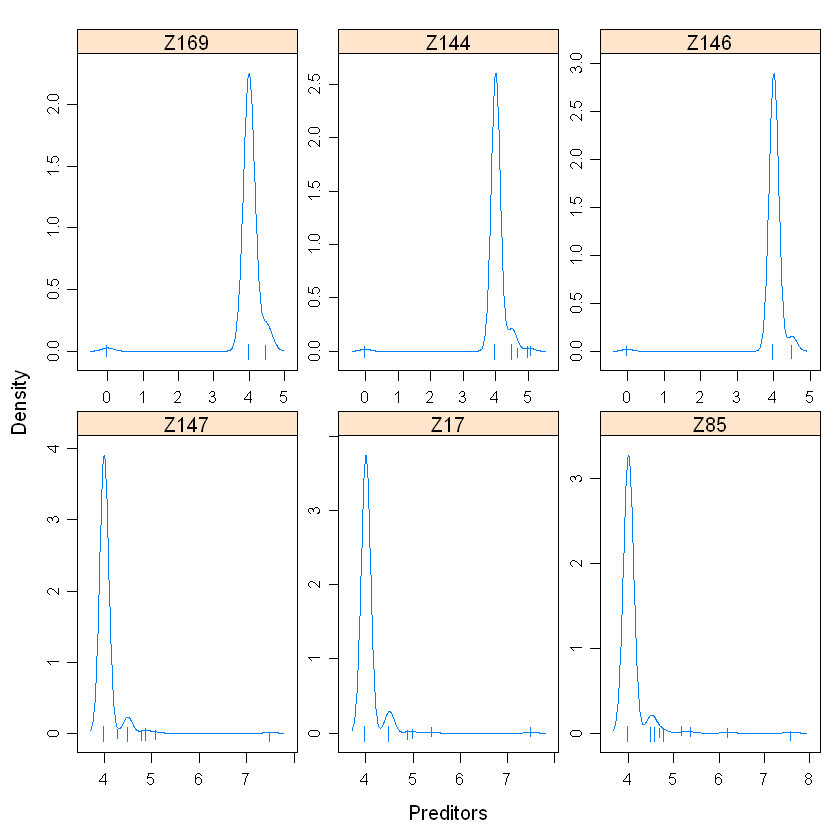

In [23]:
library(psych)
skew_info <-  describe(bio_flt_nzv)
skew_cols <- rownames(skew_info[order(skew_info$skew,decreasing = T),c("vars","skew")])[c(1:3,100:102)]
skew_plt <- bio_flt_nzv[,skew_cols]

library(reshape)
skew_plt <- melt(skew_plt)

library(lattice)
densityplot(~value|variable,data=skew_plt,
            scales = list(x=list(relation="free"),y=list(relation = "free")),
           adjust=1.25,pch="|",xlab="Preditors")

&#x25B6; `Correlations`

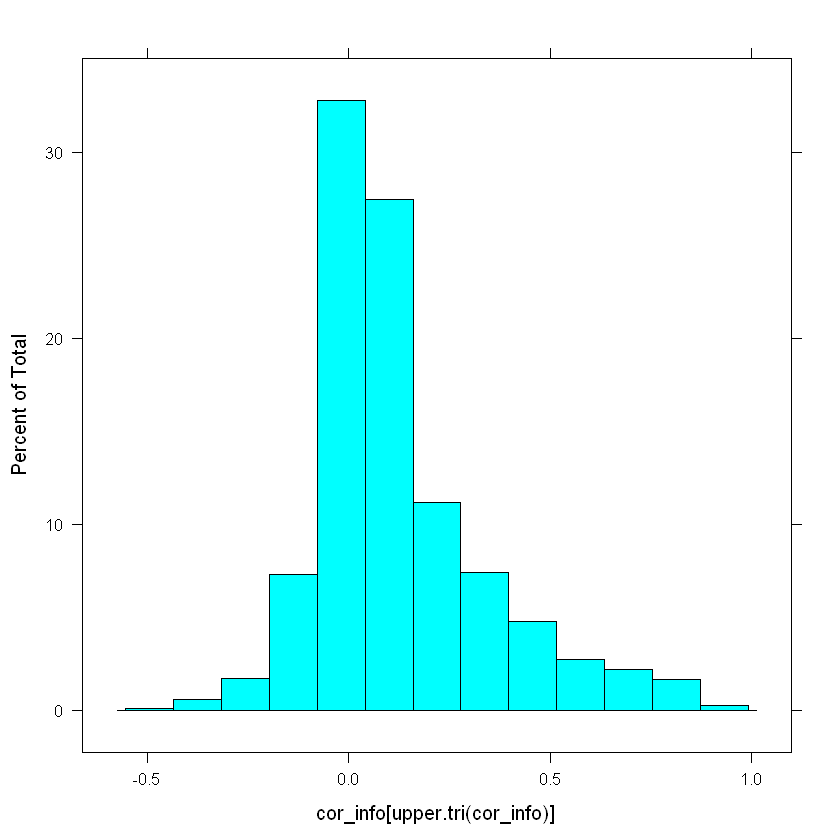

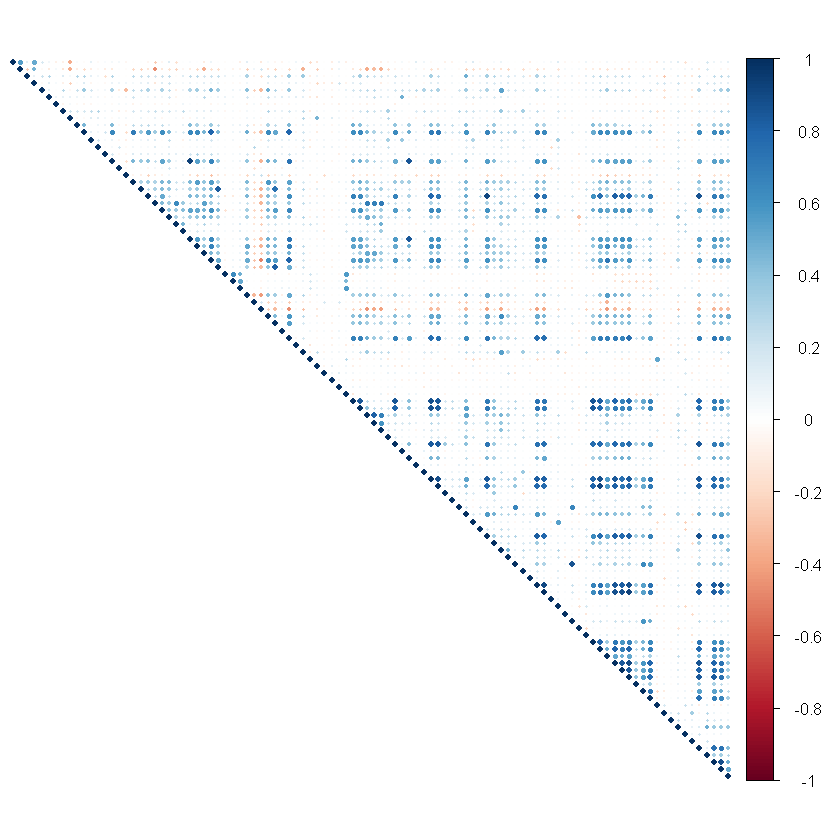

In [34]:
library(corrplot)
cor_info <- cor(bio_flt_nzv)
# summary(cor_info[upper.tri(cor_info)])

histogram(cor_info[upper.tri(cor_info)])
corrplot(cor_info,type="upper",addgrid.col = NA, tl.pos = "n")

\begin{remark}
(c) Split the data into a training and a testing set, pre-process the data, and build models described in this chapter for the biological predictors and separately for the chemical fingerprint predictors. Which model has the best predictive ability for the biological predictors and what is the optimal performance? Which model has the best predictive ability for the chemical predictors and what is the optimal performance? Based on these results, which set of predictors contains the most information about hepatic toxicity?
\end{remark}

&#x1F31F;
```r
function pROC:::roc assumes that the second class is the event of interest
```

`# Use the biological predictors`

In [35]:
library(doMC)
registerDoMC(12)
source("build_AUC_linear_models.R")
#use the original function written by  Dr. John L. Weatherwax

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



In [36]:
options(warn=-1)
X <- bio_flt_nzv
bio_linear_models <-  build_AUC_linear_models(X,any_damage)

11111111111111111111111111

In [37]:
df = rbind( data.frame(name="LR", auc=bio_linear_models$glm$auc), data.frame(name="LDA", auc=bio_linear_models$lda$auc),
            data.frame(name="PLSDA", auc=bio_linear_models$plsda$auc), data.frame(name="GLMNET", auc=bio_linear_models$glmnet$auc),
            data.frame(name="NSC", auc=bio_linear_models$nsc$auc) )
# Order our dataframe by performance:
#
df = df[ with( df, order(auc) ), ]
print( "AUC Performance using biological predictors" )
print( df )

[1] "AUC Performance using biological predictors"
    name       auc
4 GLMNET 0.6486792
3  PLSDA 0.6552022
5    NSC 0.6552022
2    LDA 0.8675472
1     LR 0.8975202


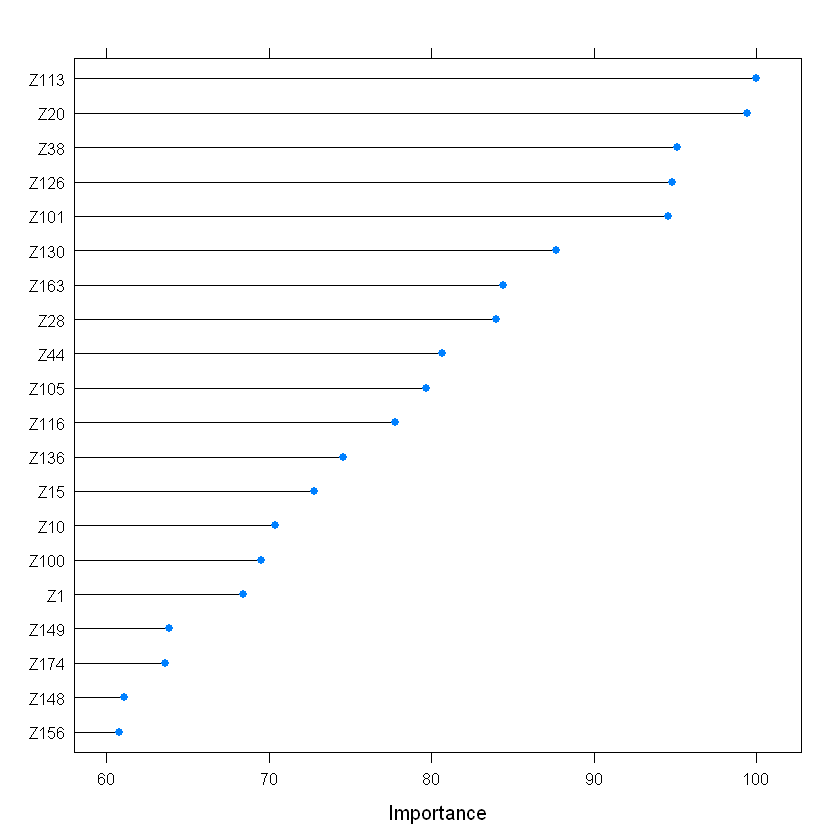

In [116]:
# For the best model (logistic regression) what are the most important predictors:
#
plot(varImp(bio_linear_models$glm$classifier),top=20)

`I made some modification base on the original function as I noticed it uses the whole dataset and did not use cross validation`
https://www.waxworksmath.com/Authors/G_M/Kuhn/Code/Chapter12/build_AUC_linear_models.R

`Let's use Logistic Regression as example to illustrate`

&#x1F52E; `Original  model by Dr.John`

In [57]:
library(caret)
ctrl <- trainControl(
                    summaryFunction=twoClassSummary,
                     classProbs=T)

set.seed(456)
fit_glm_orig <- train(x = bio_flt_nzv,y=any_damage,method = "glm",trControl=ctrl)
pred_glm <- predict(fit_glm_orig,newdata = bio_flt_nzv,type="prob")

roc_glm <- pROC::roc(response = any_damage,predictor = pred_glm[,1],levels=rev(levels(any_damage)))
auc_glm <- roc_glm$auc[1]
glm <- list(classifier=fit_glm_orig, predictions=pred_glm, roc=roc_glm, auc=auc_glm)

In [60]:
roc_glm


Call:
roc.default(response = any_damage, predictor = pred_glm[, 1],     levels = rev(levels(any_damage)))

Data: pred_glm[, 1] in 106 controls (any_damage No) < 175 cases (any_damage Yes).
Area under the curve: 0.8975

> `Arguments` response a factor, numeric or character vector of responses, typically encoded with 0 (controls) and 1 (cases). 

> [Comparisons of people with a specific cancer (cases) and similar people who do not have the cancer (controls)](https://dceg.cancer.gov/research/who-we-study/cancer-cases-controls/)

In [63]:
confusionMatrix(reference = any_damage,data = predict(fit_glm_orig,newdata = bio_flt_nzv) )

Confusion Matrix and Statistics

          Reference
Prediction Yes  No
       Yes 157  29
       No   18  77
                                          
               Accuracy : 0.8327          
                 95% CI : (0.7839, 0.8744)
    No Information Rate : 0.6228          
    P-Value [Acc > NIR] : 1.123e-14       
                                          
                  Kappa : 0.6366          
 Mcnemar's Test P-Value : 0.1447          
                                          
            Sensitivity : 0.8971          
            Specificity : 0.7264          
         Pos Pred Value : 0.8441          
         Neg Pred Value : 0.8105          
             Prevalence : 0.6228          
         Detection Rate : 0.5587          
   Detection Prevalence : 0.6619          
      Balanced Accuracy : 0.8118          
                                          
       'Positive' Class : Yes             
                                          

&#x1F52E; `Modified model using cross validation`

In [64]:
library(caret)
ctrl <- trainControl(method="repeatedcv",number=10,repeats = 10,
                    summaryFunction=twoClassSummary,
                     classProbs=T,savePredictions = T)

set.seed(456)
fit_glm_mod <- train(x = bio_flt_nzv,y=any_damage,method = "glm",trControl=ctrl)
pred_glm <- predict(fit_glm_mod,newdata = bio_flt_nzv,type="prob")

roc_glm <- pROC::roc(response = any_damage,predictor = pred_glm[,1],levels=rev(levels(any_damage)))
auc_glm <- roc_glm$auc[1]
glm <- list(classifier=fit_glm_orig, predictions=pred_glm, roc=roc_glm, auc=auc_glm)

In [65]:
fit_glm_mod

Generalized Linear Model 

281 samples
102 predictors
  2 classes: 'Yes', 'No' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 254, 253, 252, 254, 253, 252, ... 
Resampling results:

  ROC        Sens       Spec     
  0.5284226  0.6166667  0.4132727


In [66]:
pred_glm <- predict(fit_glm_mod,newdata = bio_flt_nzv,type="prob")
pROC::roc(response = any_damage,predictor = pred_glm[,1],levels=rev(levels(any_damage)))


Call:
roc.default(response = any_damage, predictor = pred_glm[, 1],     levels = rev(levels(any_damage)))

Data: pred_glm[, 1] in 106 controls (any_damage No) < 175 cases (any_damage Yes).
Area under the curve: 0.8975

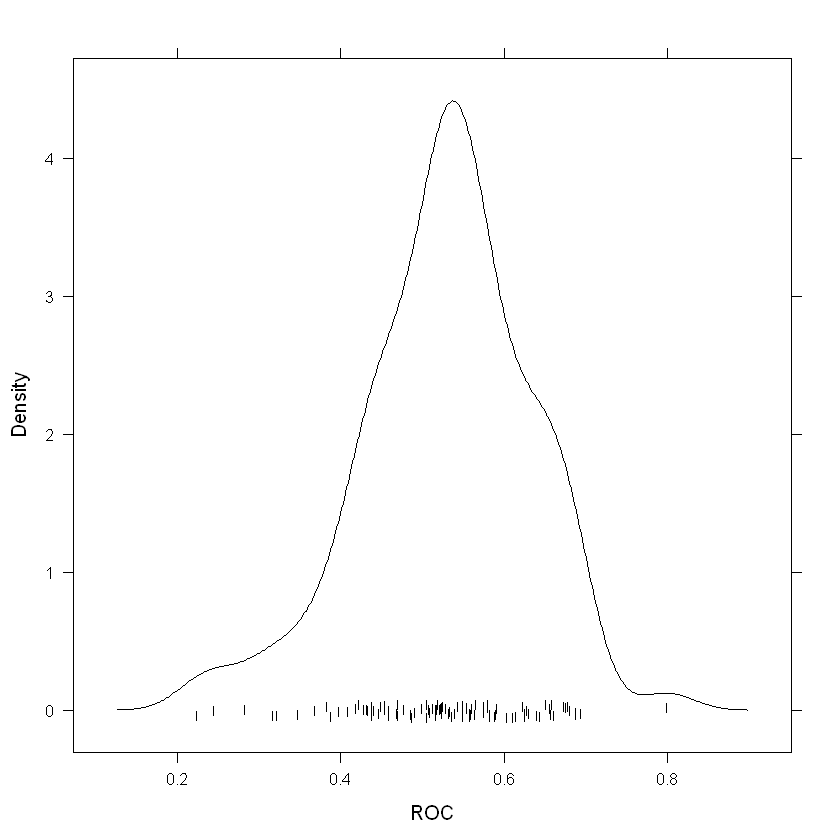

In [68]:
trellis.par.set(caretTheme())
densityplot(fit_glm_mod, pch = "|")

In [69]:
df <- cbind(bio_flt_nzv,as.data.frame(any_damage))
fit_lm <- glm(any_damage~.,data=df,family = binomial(link="logit")) 

In [70]:
summary(fit_lm)


Call:
glm(formula = any_damage ~ ., family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1959  -0.6653  -0.1364   0.4226   2.4416  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -35.93186   27.18949  -1.322 0.186323    
Z1            1.73558    0.95517   1.817 0.069210 .  
Z4            0.84485    0.89027   0.949 0.342630    
Z6           -0.52795    1.13656  -0.465 0.642278    
Z7           -1.35189    0.77652  -1.741 0.081691 .  
Z10           1.67324    1.25363   1.335 0.181970    
Z11          -0.82900    1.01931  -0.813 0.416049    
Z12           0.63389    1.38225   0.459 0.646527    
Z15          -1.44195    0.60876  -2.369 0.017853 *  
Z17          -0.20794    1.51948  -0.137 0.891152    
Z18           1.23666    1.22991   1.005 0.314661    
Z19           0.92847    0.85419   1.087 0.277052    
Z20          -2.84602    1.07669  -2.643 0.008210 ** 
Z21          -1.18966    0.

In [71]:
fit_lm$fitted.values

1            2            3            4            5            6 
6.260914e-01 7.361907e-01 9.992517e-01 2.159033e-05 3.900503e-01 2.334117e-02 
           7            8            9           10           11           12 
6.556789e-01 2.069912e-01 9.860020e-01 9.944217e-01 9.350300e-01 3.120612e-01 
          13           14           15           16           17           18 
1.725583e-01 1.000000e+00 5.583350e-01 5.283825e-02 2.225372e-01 1.748324e-01 
          19           20           21           22           23           24 
8.699553e-01 6.010829e-01 4.257693e-01 1.907532e-01 5.415517e-01 1.154473e-01 
          25           26           27           28           29           30 
2.804059e-01 1.367939e-01 2.348876e-02 9.808848e-01 7.012563e-01 9.945083e-01 
          31           32           33           34           35           36 
4.099615e-01 2.220992e-02 2.629917e-01 9.950048e-01 5.177642e-01 7.093739e-02 
          37           38           39           40           41           42 
5.762108e-02 2.071917e-03 3.647759e-01 2.856051e-01 1.093904e-01 9.983353e-01 
          43           44           45           46           47           48 
7.835064e-01 3.222527e-01 1.000000e+00 5.168154e-02 3.891538e-01 8.116364e-04 
          49           50           51           52           53           54 
6.989097e-01 6.398624e-01 5.541456e-01 4.138031e-01 5.639050e-01 3.871274e-01 
          55           56           57           58           59           60 
2.555099e-02 9.987744e-01 2.077242e-01 9.545128e-01 5.075675e-10 2.222851e-01 
          61           62           63           64           65           66 
9.864259e-01 3.642231e-01 1.435488e-01 2.129380e-01 6.235363e-02 5.689708e-01 
          67           68           69           70           71           72 
5.808793e-01 9.145771e-01 9.998747e-01 8.568912e-01 5.320234e-03 8.607038e-02 
          73           74           75           76           77           78 
9.297229e-01 9.999999e-01 3.175334e-01 1.566194e-01 8.084592e-02 5.330205e-01 
          79           80           81           82           83           84 
2.072902e-01 9.051896e-01 3.685969e-01 3.902358e-03 9.066147e-01 5.868343e-01 
          85           86           87           88           89           90 
9.428144e-01 6.355476e-01 9.903160e-01 5.663818e-01 2.943276e-01 9.984577e-01 
          91           92           93           94           95           96 
7.166497e-01 1.304894e-02 2.454561e-01 7.519736e-01 3.247506e-01 2.548250e-01 
          97           98           99          100          101          102 
1.099893e-05 2.752395e-03 1.312377e-01 9.972939e-01 3.466731e-01 3.225194e-01 
         103          104          105          106          107          108 
9.999982e-01 6.634723e-04 9.796286e-01 2.806268e-01 9.999963e-01 1.175042e-01 
         109          110          111          112          113          114 
1.102471e-01 8.833808e-03 9.653770e-01 9.752784e-01 7.129153e-01 5.945274e-01 
         115          116          117          118          119          120 
6.091708e-05 5.498570e-01 8.185857e-01 4.432202e-01 7.676591e-02 8.982854e-01 
         121          122          123          124          125          126 
8.030570e-01 2.081832e-01 8.990891e-01 4.212774e-01 3.452622e-01 7.904619e-01 
         127          128          129          130          131          132 
3.100641e-01 9.541464e-01 7.950584e-01 2.166765e-01 8.069622e-01 9.695100e-01 
         133          134          135          136          137          138 
1.128160e-01 5.570996e-02 5.983531e-03 7.795813e-01 6.181867e-04 2.692689e-01 
         139          140          141          142          143          144 
2.922380e-01 3.143767e-01 6.135169e-02 3.736154e-06 2.375254e-07 7.091714e-01 
         145          146          147          148          149          150 
3.334628e-01 2.098681e-02 9.774034e-01 5.196530e-01 2.579593e-02 3.974254e-01 
         151          152          153          154          

In [75]:
library(ROCR)
# pred = 1-predict(fit_lm,type="response")
pred <- 1-fit_lm$fitted.values #prop of  cases
head(pred)

1            2            3            4            5            6 
0.3739085614 0.2638092578 0.0007483222 0.9999784097 0.6099497111 0.9766588276

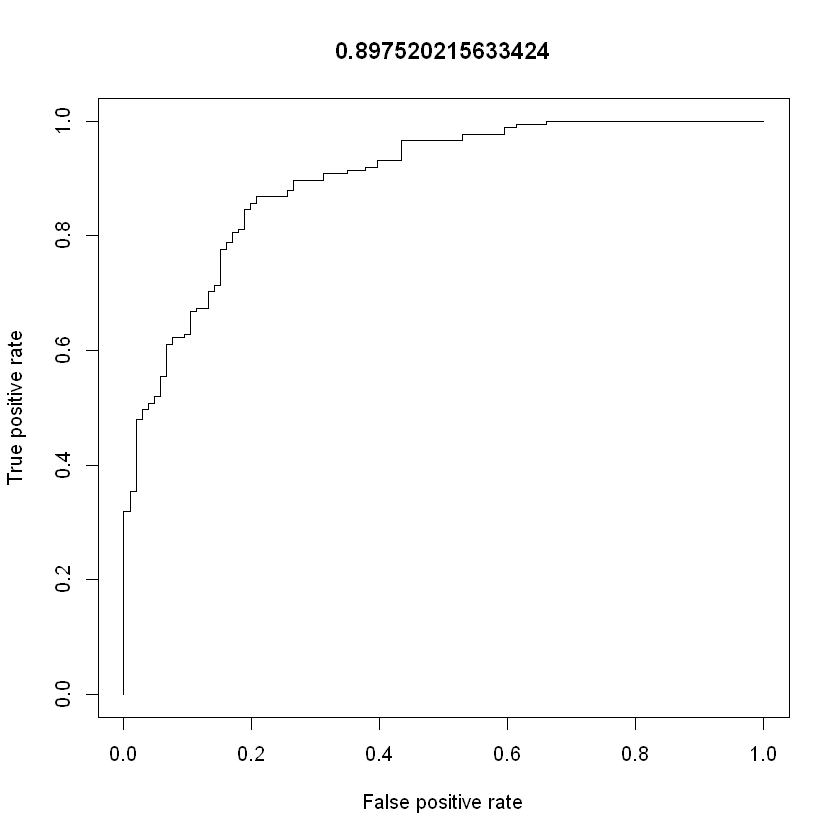

In [76]:
pred_obj <- prediction(pred,df$any_damage)
roc_obj <- performance(pred_obj,measure = "tpr",x.measure = "fpr")
auc_obj <- performance(pred_obj,measure = "auc")
plot(roc_obj,main=paste(auc_obj@y.values[[1]]))

> <font color=#3b5998>**Aurelien Geron (2017)**</font> You don't want to touch the test set until you are ready to lunch a model you are confident about. 

As we can see, the logit regression model is overfitting badly (from the densityplot of resample results), so I would do set aside the testset, even there aren't much of samples left.


In [96]:
dim(bio_flt_nzv[trn_id,])

[1] 225 102

In [54]:
build_AUC_linear_models = function(X, y, trn_id = trn_id, seed_value=456){

    # Set up the train control arguments so that we can compute the area-under-the-curve:
    #
    ctrl = trainControl( 
        summaryFunction=twoClassSummary, 
        classProbs=T,
        savePredictions = T,
        method="repeatedcv",number=10,repeats=10)

    # Logistic Regression Model:
    #
    set.seed(seed_value)
    glm.classifier = train( X[trn_id,], y[trn_id], method="glm", metric="ROC", trControl=ctrl )
    glm.predictions = predict( glm.classifier, X[-trn_id,], type="prob" )
    glm.rocCurve = pROC::roc( response=y[-trn_id], predictor=glm.predictions[,1],levels=rev(levels(any_damage)) )
    glm.auc = glm.rocCurve$auc[1]
    glm=list( classifier=glm.classifier, predictions=glm.predictions, roc=glm.rocCurve, auc=glm.auc )

    # Linear Discriminant Analysis:
    #
    set.seed(seed_value)
    lda.classifier = train( X[trn_id,], y[trn_id], method="lda", preProc=c("center","scale"), metric="ROC", trControl=ctrl )
    lda.predictions = predict( lda.classifier, X[-trn_id,], type="prob" )
    lda.rocCurve = pROC::roc( response=y[-trn_id], predictor=lda.predictions[,1],levels=rev(levels(any_damage)) )
    lda.auc = lda.rocCurve$auc[1]
    lda=list( classifier=lda.classifier, predictions=lda.predictions, roc=lda.rocCurve, auc=lda.auc )

    # Partial Least Squares Discriminant Analysis:
    #
    set.seed(seed_value)
    plsda.classifier = train( X[trn_id,], y[trn_id], method="pls", tuneGrid=expand.grid(.ncomp=1:10), preProc=c("center","scale"), metric="ROC", trControl=ctrl )
    plsda.predictions = predict( plsda.classifier, X[-trn_id,], type="prob" )
    plsda.rocCurve = pROC::roc( response=y[-trn_id], predictor=plsda.predictions[,1],levels=rev(levels(any_damage)) )
    plsda.auc = plsda.rocCurve$auc[1]
    plsda=list( classifier=plsda.classifier, predictions=plsda.predictions, roc=plsda.rocCurve, auc=plsda.auc )

    # Penalized Methods:
    #
    glmnGrid = expand.grid(.alpha=c(0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0), .lambda=seq( 0.01, 0.2, length=40))
    set.seed(seed_value)
    glmnet.classifier = train( X[trn_id,], y[trn_id], method="glmnet", tuneGrid=glmnGrid, preProc=c("center","scale"), metric="ROC", trControl=ctrl )
    glmnet.predictions = predict( glmnet.classifier, X[-trn_id,], type="prob" )
    glmnet.rocCurve = pROC::roc( response=y[-trn_id], predictor=glmnet.predictions[,1],levels=rev(levels(any_damage)) )
    glmnet.auc = glmnet.rocCurve$auc[1]
    glmnet=list( classifier=glmnet.classifier, predictions=glmnet.predictions, roc=glmnet.rocCurve, auc=glmnet.auc )

    # Nearest shrunken Centroids:
    #
    nscGrid = expand.grid(.threshold=0:25)
    set.seed(seed_value)
    nsc.classifier = train( X[trn_id,], y[trn_id], method="pam", tuneGrid=nscGrid, preProc=c("center","scale"), metric="ROC", trControl=ctrl )
    nsc.predictions = predict( nsc.classifier, X[-trn_id,], type="prob" )
    nsc.rocCurve = pROC::roc( response=y[-trn_id], predictor=nsc.predictions[,1],levels=rev(levels(any_damage)) )
    nsc.auc = nsc.rocCurve$auc[1]
    nsc=list( classifier=nsc.classifier, predictions=nsc.predictions, roc=nsc.rocCurve, auc=nsc.auc )
    
    # Ourput:
    resamps <- resamples(list(GLM = glm.classifier,
                              LDA = lda.classifier,
                              PLSDA = plsda.classifier,
                              GLMNET = glmnet.classifier,
                              NSC = nsc.classifier))
    result = list(  resamps=resamps, glm=glm, lda=lda, plsda=plsda, glmnet=glmnet, nsc=nsc )

    return(result)

}

In [79]:
bio_linear_models <-  build_AUC_linear_models(bio_flt_nzv,any_damage,trn_id)
# summary(bio_linear_models)

11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [88]:
difValues <- diff(bio_linear_models$resamps)
summary(difValues)


Call:
summary.diff.resamples(object = difValues)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

ROC 
       GLM LDA        PLSDA      GLMNET     NSC       
GLM        -1.407e-02 -7.976e-03 -7.465e-03 -7.976e-03
LDA    1               6.091e-03  6.602e-03  6.091e-03
PLSDA  1   1                      5.109e-04  5.554e-19
GLMNET 1   1          1                     -5.109e-04
NSC    1   1          1          1                    

Sens 
       GLM       LDA       PLSDA     GLMNET   NSC     
GLM              -0.06357  -0.28643  -0.25429 -0.24000
LDA    1.066e-05           -0.22286  -0.19071 -0.17643
PLSDA  < 2.2e-16 < 2.2e-16            0.03214  0.04643
GLMNET < 2.2e-16 < 2.2e-16 0.05677             0.01429
NSC    < 2.2e-16 < 2.2e-16 5.504e-12 1.00000          

Spec 
       GLM       LDA       PLSDA     GLMNET   NSC     
GLM               0.04958   0.24847   0.20139  0.19042
LDA    0.009287             0.19889 

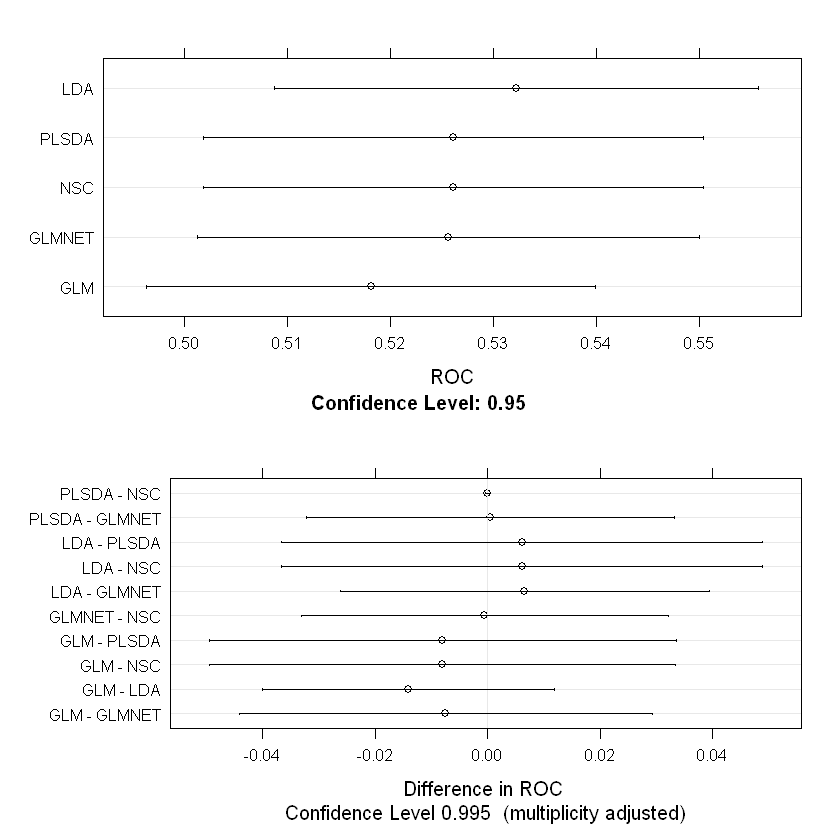

In [92]:
trellis.par.set(caretTheme())
p1 <- dotplot(bio_linear_models$resamps, metric = "ROC")
p2 <- dotplot(difValues)
library(gridExtra)
grid.arrange(p1,p2,ncol=1,nrow=2)

[1] "AUC Performance using biological predictors"
    name       auc
3  PLSDA 0.6217687
5    NSC 0.6217687
4 GLMNET 0.5850340
1     LR 0.5421769
2    LDA 0.5088435


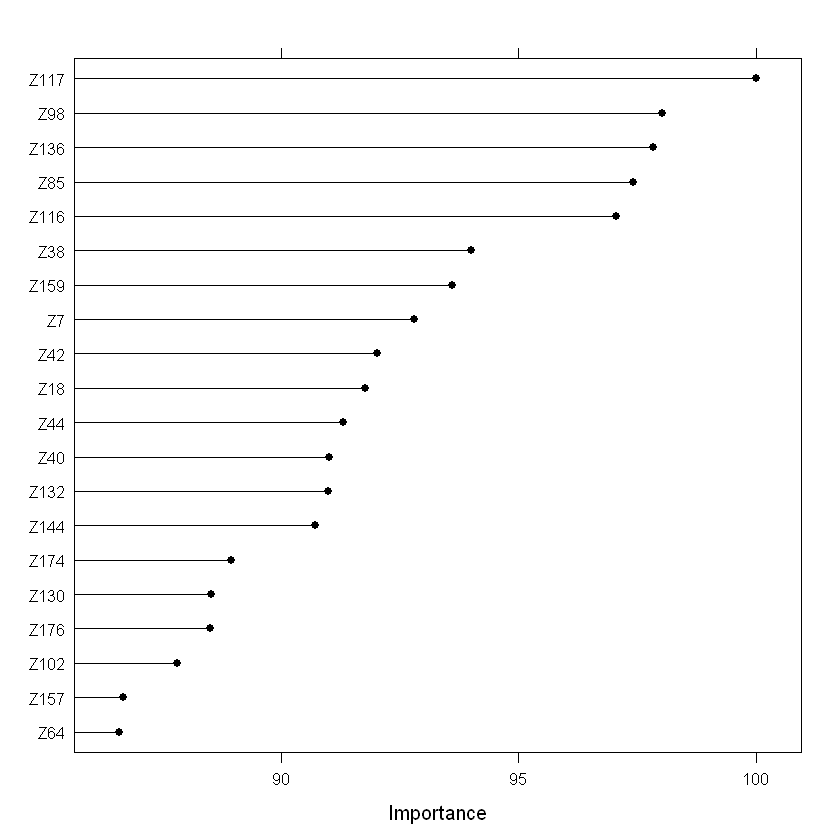

In [83]:
# Present the sampled ROC estimate for each model:
#
df = rbind( data.frame(name="LR", auc=bio_linear_models$glm$auc), data.frame(name="LDA", auc=bio_linear_models$lda$auc),
            data.frame(name="PLSDA", auc=bio_linear_models$plsda$auc), data.frame(name="GLMNET", auc=bio_linear_models$glmnet$auc),
            data.frame(name="NSC", auc=bio_linear_models$nsc$auc) )

# Order our dataframe by performance:
#
df = df[ with( df, order(auc,decreasing = T) ), ]
print( "AUC Performance using biological predictors" )
print( df )

# For the best model (logistic regression) what are the most important predictors:
#
plot(varImp(bio_linear_models$glm$classifier),top=20)

&#x1F52C; `Use the chemical predictors`


In [98]:
dim(chem)

[1] 281 192

In [151]:
any(is.null(chem))

[1] FALSE

In [152]:
nearZeroVar(chem,names=T)
chem_flt_nzv <- chem[,-nearZeroVar(chem)]

[1] "X8"   "X9"   "X10"  "X32"  "X41"  "X42"  "X43"  "X45"  "X46"  "X48" 
[11] "X54"  "X55"  "X56"  "X57"  "X58"  "X59"  "X60"  "X70"  "X75"  "X76" 
[21] "X77"  "X78"  "X79"  "X80"  "X92"  "X93"  "X94"  "X96"  "X100" "X107"
[31] "X108" "X110" "X111" "X112" "X114" "X115" "X116" "X117" "X119" "X128"
[41] "X129" "X152" "X156" "X158" "X162" "X163" "X174" "X178" "X180" "X181"
[51] "X182" "X183" "X184" "X185" "X186" "X189" "X190" "X192"

In [157]:
library(e1071)
skew_info <- apply(chem_flt_nzv,2,skewness)
head(sort(skew_info,decreasing = T))
tail(sort(skew_info,decreasing = T))

X1      X127      X187       X73       X74       X64 
13.819461  7.275978  7.140697  6.453736  6.173066  6.132292

X19      X169       X18      X123       X15        X2 
0.3539929 0.3211949 0.3104187 0.2611149 0.2452904 0.0239475

In [164]:
linear_cols <- findLinearCombos(chem_flt_nzv)
colnames(chem_flt_nzv)[linear_cols$remove]
chem_flt_linear <- chem_flt_nzv[,-linear_cols$remove]

[1] "X12"  "X15"  "X16"  "X17"  "X18"  "X24"  "X53"  "X67"  "X73"  "X74" 
[11] "X86"  "X95"  "X98"  "X123" "X125" "X171" "X173"

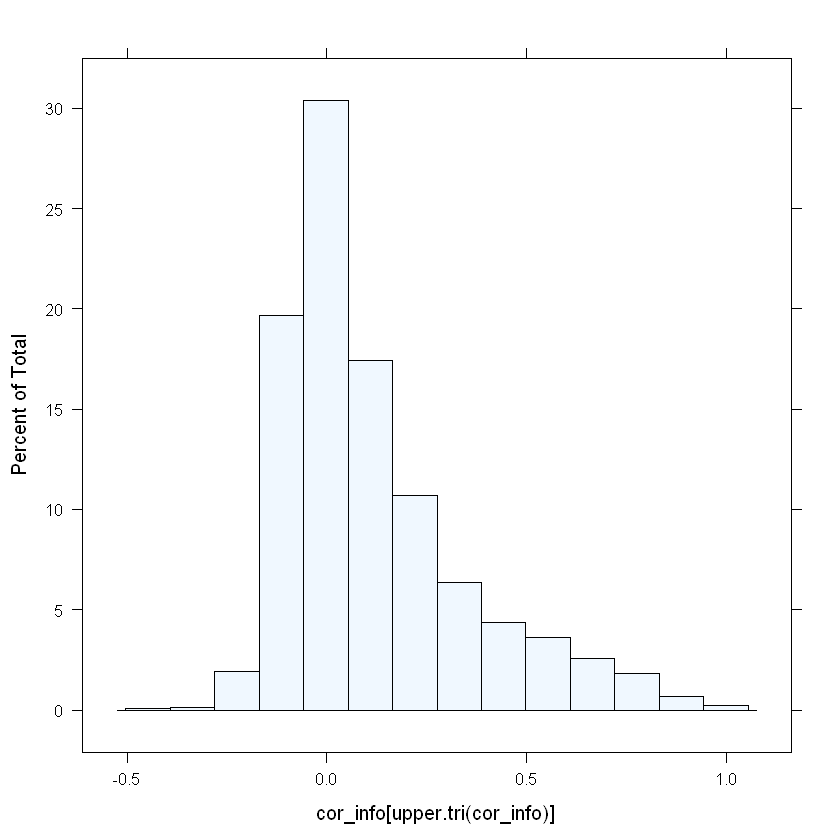

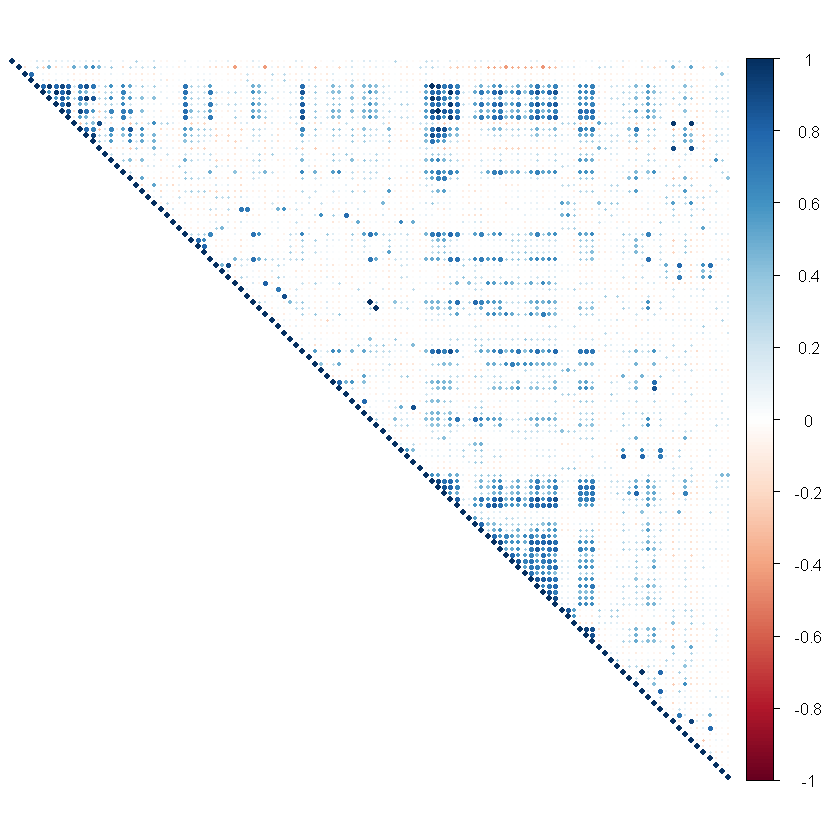

In [165]:
library(corrplot)
cor_info <- cor(chem_flt_linear)
# summary(cor_info[upper.tri(cor_info)])

histogram(cor_info[upper.tri(cor_info)])
corrplot(cor_info,type="upper",addgrid.col = NA, tl.pos = "n")

In [166]:
# Build linear models with this data:
chem_linear_models <- build_AUC_linear_models( chem_flt_linear,any_damage,trn_id )

11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [167]:
difValues <- diff(chem_linear_models$resamps)
summary(difValues)


Call:
summary.diff.resamples(object = difValues)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

ROC 
       GLM       LDA       PLSDA     GLMNET    NSC      
GLM              -0.058636 -0.005134 -0.003993  0.056791
LDA    4.348e-08            0.053502  0.054643  0.115427
PLSDA  1.0000000 0.0009559            0.001141  0.061925
GLMNET 1.0000000 0.0003123 1.0000000            0.060784
NSC    0.0033523 2.668e-11 5.505e-05 2.521e-05          

Sens 
       GLM       LDA       PLSDA     GLMNET    NSC      
GLM              -0.075000 -0.085714 -0.090000 -0.242143
LDA    2.426e-06           -0.010714 -0.015000 -0.167143
PLSDA  2.342e-06 1                   -0.004286 -0.156429
GLMNET 1.520e-07 1         1                   -0.152143
NSC    < 2.2e-16 2.613e-16 < 2.2e-16 < 2.2e-16          

Spec 
       GLM       LDA       PLSDA     GLMNET    NSC     
GLM              -0.01111   0.06236   0.07361   0.37903
LDA    1.0

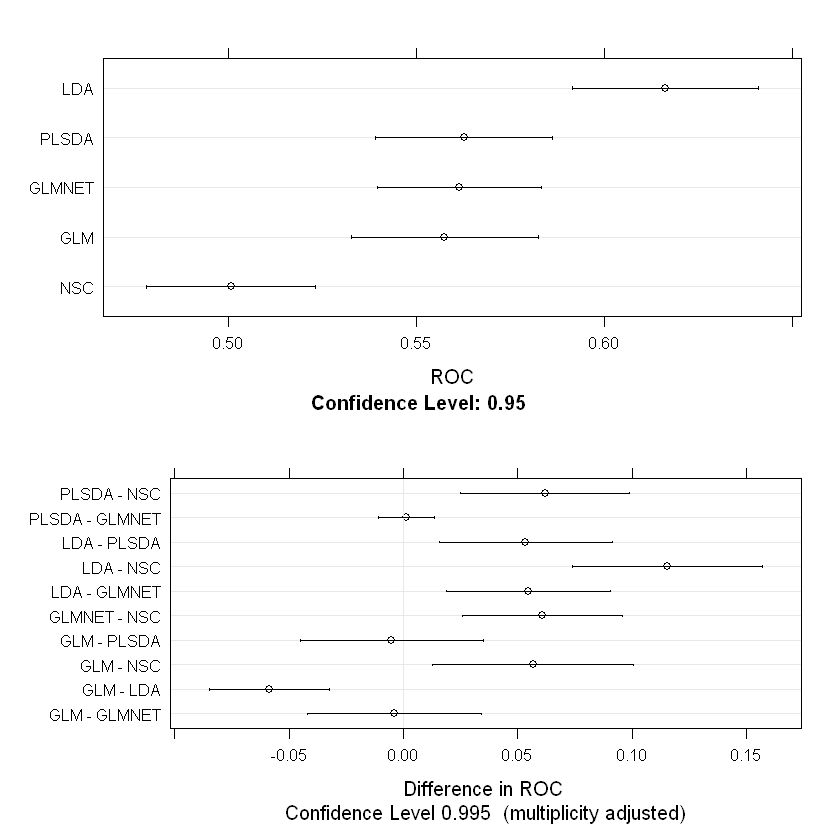

In [168]:
trellis.par.set(caretTheme())
p1 <- dotplot(chem_linear_models$resamps, metric = "ROC")
p2 <- dotplot(difValues)
library(gridExtra)
grid.arrange(p1,p2,ncol=1,nrow=2)

`Seems LDA outperfoms the other models on chem predictors`

&#x1F52C; `Use ALL predictors into one set of predictors`

In [171]:
all_vars <- cbind(bio,chem)
all_vars_nzv <- all_vars[,-nearZeroVar(all_vars)]
all_vars_flt <- all_vars_nzv[,-findLinearCombos(all_vars_nzv)$remove]

In [173]:
dim(all_vars_flt)

[1] 281 219

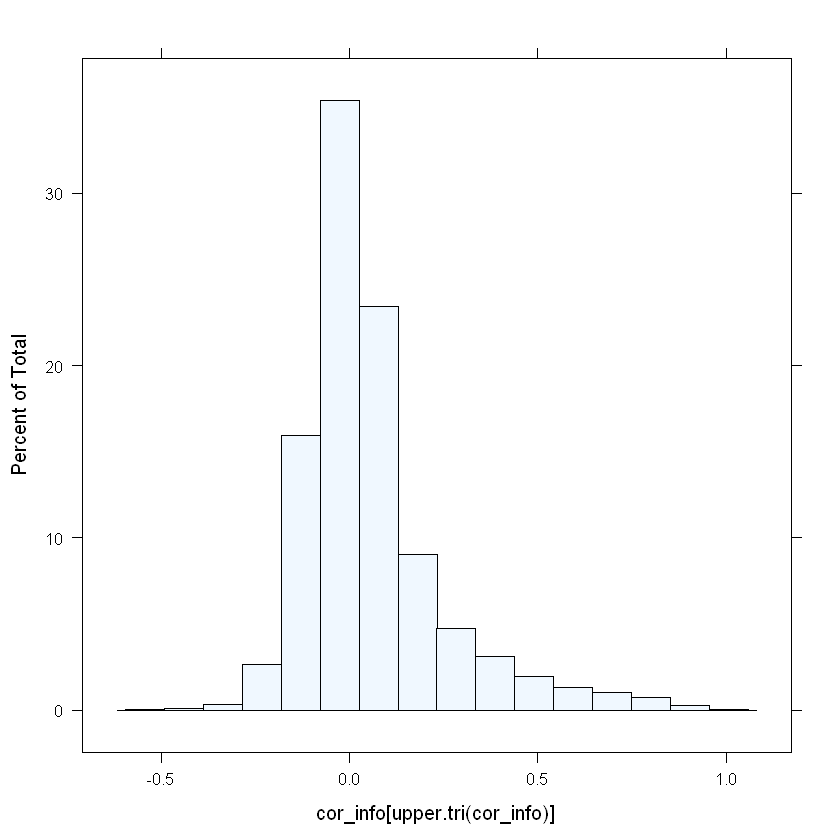

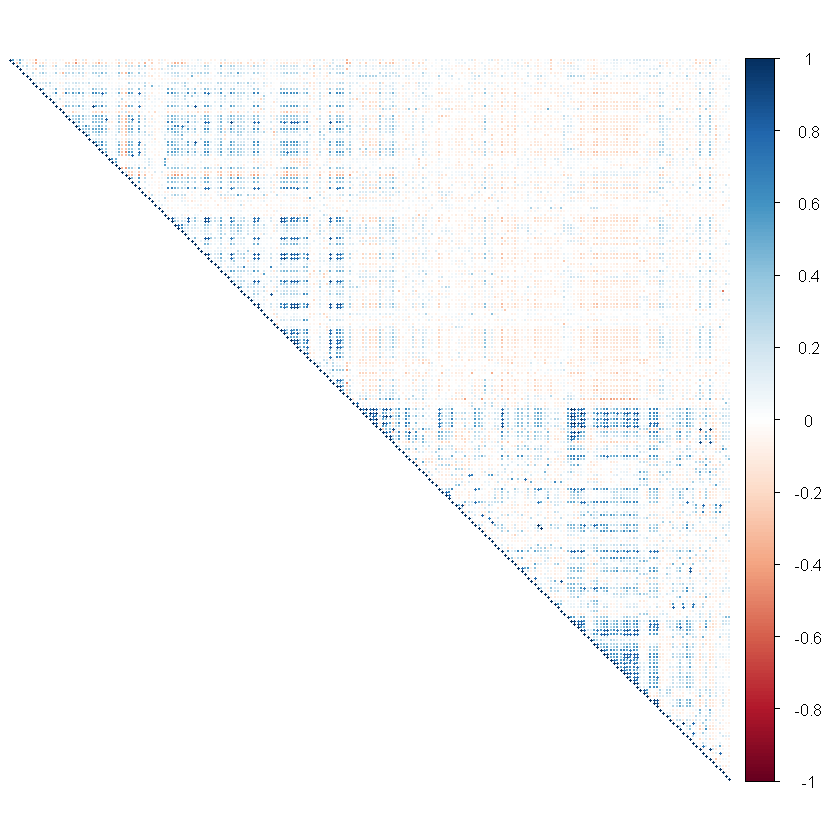

In [174]:
library(corrplot)
cor_info <- cor(all_vars_flt)
# summary(cor_info[upper.tri(cor_info)])

histogram(cor_info[upper.tri(cor_info)])
corrplot(cor_info,type="upper",addgrid.col = NA, tl.pos = "n")

In [175]:
# Build linear models with this data:
all_linear_models <- build_AUC_linear_models( all_vars_flt,any_damage,trn_id )

11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111


Call:
summary.diff.resamples(object = difValues)

p-value adjustment: bonferroni 
Upper diagonal: estimates of the difference
Lower diagonal: p-value for H0: difference = 0

ROC 
       GLM    LDA       PLSDA     GLMNET    NSC      
GLM           -0.041066 -0.029311 -0.032078 -0.008914
LDA    0.1002            0.011756  0.008988  0.032153
PLSDA  0.5731 1.0000              -0.002768  0.020397
GLMNET 0.3588 1.0000    1.0000               0.023165
NSC    1.0000 0.5976    0.5659    0.8375             

Sens 
       GLM       LDA        PLSDA      GLMNET     NSC       
GLM              -0.0471429 -0.2492857 -0.1314286 -0.2485714
LDA    0.1931               -0.2021429 -0.0842857 -0.2014286
PLSDA  < 2.2e-16 < 2.2e-16              0.1178571  0.0007143
GLMNET 1.462e-10 6.243e-05  2.217e-12             -0.1171429
NSC    < 2.2e-16 < 2.2e-16  1.0000     6.220e-12            

Spec 
       GLM       LDA       PLSDA     GLMNET    NSC     
GLM              -0.01208   0.20083   0.07097   0.21958
LDA 

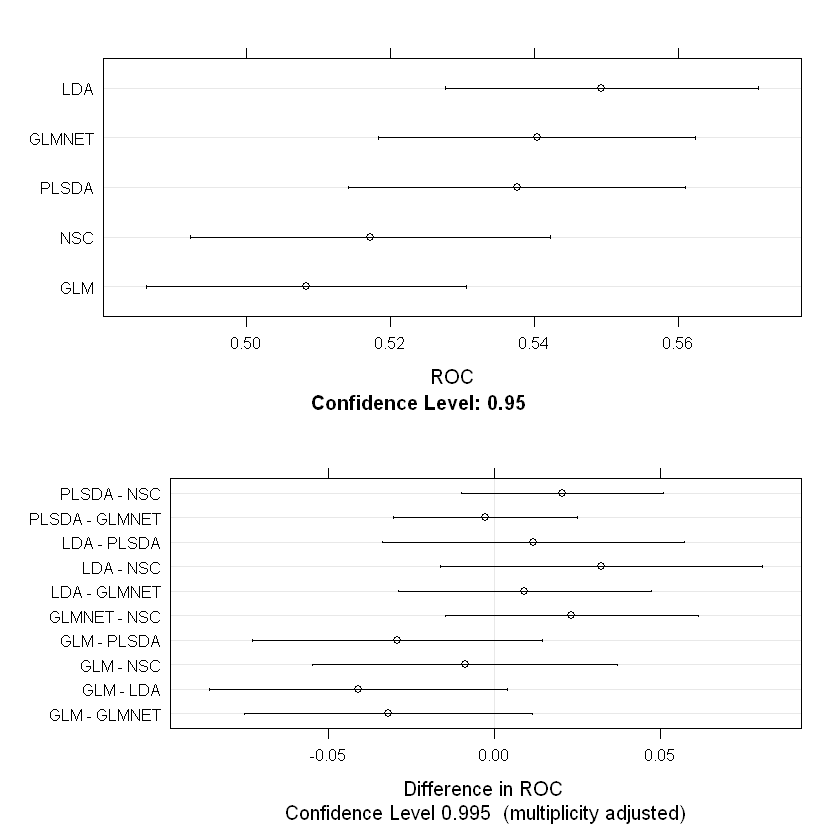

In [176]:
difValues <- diff(all_linear_models$resamps)
summary(difValues)

trellis.par.set(caretTheme())
p1 <- dotplot(all_linear_models$resamps, metric = "ROC")
p2 <- dotplot(difValues)
library(gridExtra)
grid.arrange(p1,p2,ncol=1,nrow=2)

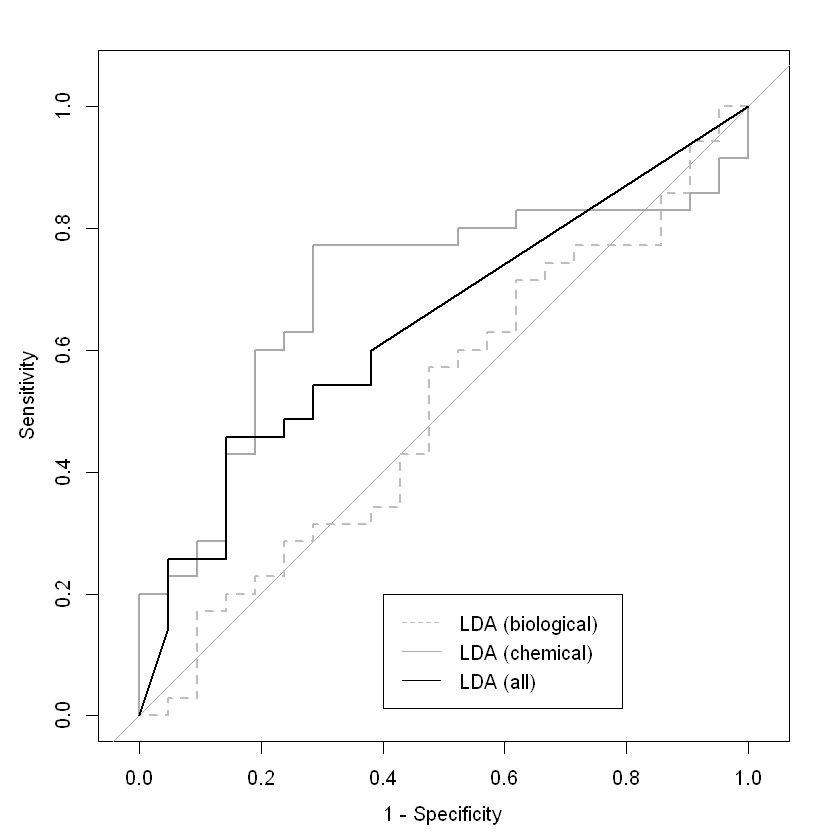

In [178]:
plot( bio_linear_models$lda$roc, legacy.axes=T, add=F, col="gray", lty=2, ylim=c(0,1.05) )
plot( chem_linear_models$lda$roc, legacy.axes=T, add=T, col="darkgray" )
plot( all_linear_models$lda$roc, legacy.axes=T, add=T )
legend( 0.6, 0.2, c("LDA (biological)","LDA (chemical)", "LDA (all)"), col=c("gray","darkgray","black"), lty=c(2,1,1) )

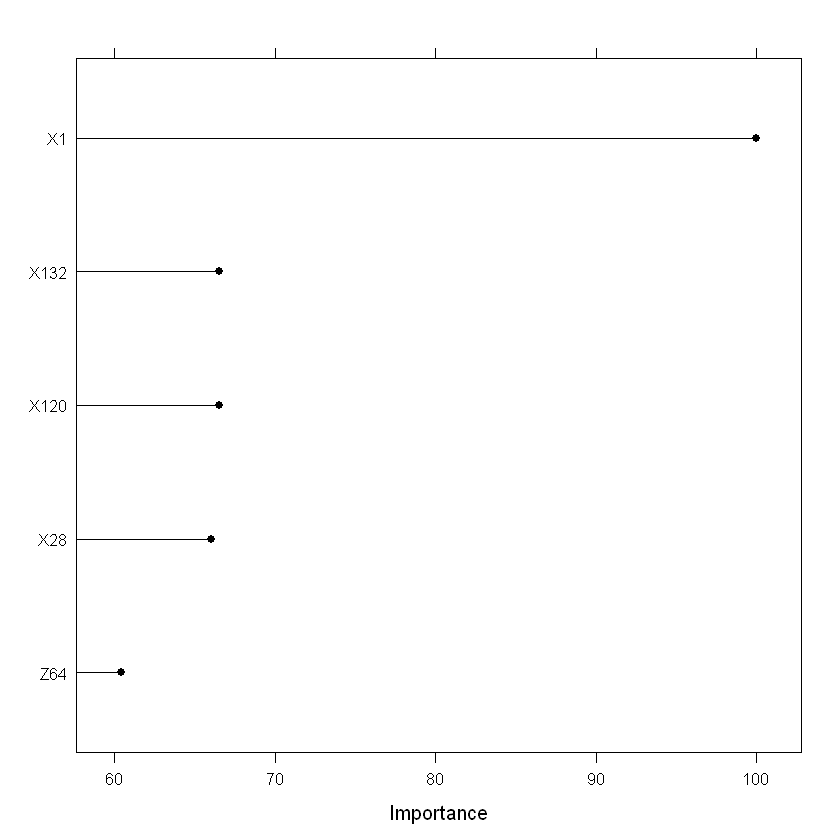

In [179]:
plot(varImp(all_linear_models$lda$classifier),top=5)

&#x1F31F;

12.2. In Exercise 4.4, we described a data set which contained 96 oil samples each from one of seven types of oils (pumpkin, sunflower, peanut, olive,
soybean, rapeseed, and corn). Gas chromatography was performed on each sample and the percentage of each type of 7 fatty acids was determined. We would like to use these data to build a model that predicts the type of oil based on a sample’s fatty acid percentages.
- (a) Like the hepatic injury data, these data suffer from extreme imbalance. Given this imbalance, should the data be split into training and test sets?
- (b) Which classification statistic would you choose to optimize for this exercise and why?
- (c) Of the models presented in this chapter, which performs best on these data? Which oil type does the model most accurately predict? Least accurately predict?

In [203]:
data(oil)
dim(fattyAcids)

[1] 96  7

In [191]:
round(prop.table(table(oilType)),2)

oilType
   A    B    C    D    E    F    G 
0.39 0.27 0.03 0.07 0.11 0.10 0.02 

In [197]:
nearZeroVar(fattyAcids,names = T)

character(0)

In [198]:
findLinearCombos(fattyAcids)

$linearCombos
list()

$remove
NULL

In [242]:
build_PCC_linear_models = function(X, y, seed_value=456){
    #
    # Builds (using caret's train function) several of the linear models discussed in
    # this chapter of the book optimizing the probability of correct classification PCC (i.e. accuracy).
    #
    # X [n samples, n features] needs to have zero variance columns removed (use nearZeroVar to remove them) and
    # linear dependent columns removed (use findLinearCombos to remove them)
    #
    # y [n samples, 1] is a two factor vector of predictions with the FIRST factor corresponding to the event of interest
    #
    # Written by:
    # -- 
    # John L. Weatherwax                2009-04-21
    # 
    # email: wax@alum.mit.edu
    # 
    # Please send comments and especially bug reports to the
    # above email address.
    #
    #-----

    # Linear Discriminant Analysis:
    #
    set.seed(seed_value)
    lda.classifier = train( X, y, method="lda", preProc=c("center","scale") ,
                          trControl = trainControl(method = "repeatedcv",repeats = 10,number=10))
    y_hat = predict( lda.classifier, X )
    cm = confusionMatrix( data=y_hat, reference=y )

    lda=list( classifier=lda.classifier, confusionMatrix=cm )

    # Penalized Methods:
    #
    glmnGrid = expand.grid(.alpha=c(0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0), .lambda=seq( 0.01, 0.2, length=40))
    set.seed(seed_value)
    glmnet.classifier = train( X, y, method="glmnet", tuneGrid=glmnGrid, preProc=c("center","scale"),
                             trControl = trainControl(method = "repeatedcv",repeats = 10,number=10))
    y_hat = predict( glmnet.classifier, X )
    cm = confusionMatrix( data=y_hat, reference=y )
    glmnet=list( Classifier=glmnet.classifier, confusionMatrix=cm )

    # Nearest Shrunken Centroids:
    #
    nscGrid = expand.grid(.threshold=0:25)
    set.seed(seed_value)
    nsc.classifier = train( X, y, method="pam", tuneGrid=nscGrid, preProc=c("center","scale"),
                          trControl = trainControl(method = "repeatedcv",repeats = 10,number=10))
    y_hat = predict( nsc.classifier, X )
    cm = confusionMatrix( data=y_hat, reference=y )
    nsc=list( classifier=nsc.classifier, confusionMatrix=cm )

    return( list( lda=lda, glmnet=glmnet, nsc=nsc ) )

}


In [230]:
oil_type <- factor(as.character(oilType))

In [243]:
options(warn=-1)
linear_models = build_PCC_linear_models( fattyAcids, oil_type )

In [244]:
# Present the sampled accuracy estimates for each model:
#
df = rbind( data.frame(name="LDA", Accuracy=linear_models$lda$confusionMatrix$overall[1]),
            data.frame(name="GLMNET", Accuracy=linear_models$glmnet$confusionMatrix$overall[1]),
            data.frame(name="NSC", Accuracy=linear_models$nsc$confusionMatrix$overall[1]) )
rownames(df) = NULL

# Order our dataframe by performance:
#
df = df[ with( df, order(Accuracy) ), ]
print( "ACCURACY Performance on the oil dataset" )
print( df )

# For the NSC model ... where is it making its errors:
#
print( linear_models$nsc$confusionMatrix )

[1] "ACCURACY Performance on the oil dataset"
    name  Accuracy
1    LDA 0.9687500
3    NSC 0.9791667
2 GLMNET 1.0000000
Confusion Matrix and Statistics

          Reference
Prediction  A  B  C  D  E  F  G
         A 35  0  0  0  0  0  0
         B  2 26  0  0  0  0  0
         C  0  0  3  0  0  0  0
         D  0  0  0  7  0  0  0
         E  0  0  0  0 11  0  0
         F  0  0  0  0  0 10  0
         G  0  0  0  0  0  0  2

Overall Statistics
                                          
               Accuracy : 0.9792          
                 95% CI : (0.9268, 0.9975)
    No Information Rate : 0.3854          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9722          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E Class: F
Sensitivity            0.9459   1.0000  1.00000  1.00000   1.0000   1.0000
Specificity            1.0000   

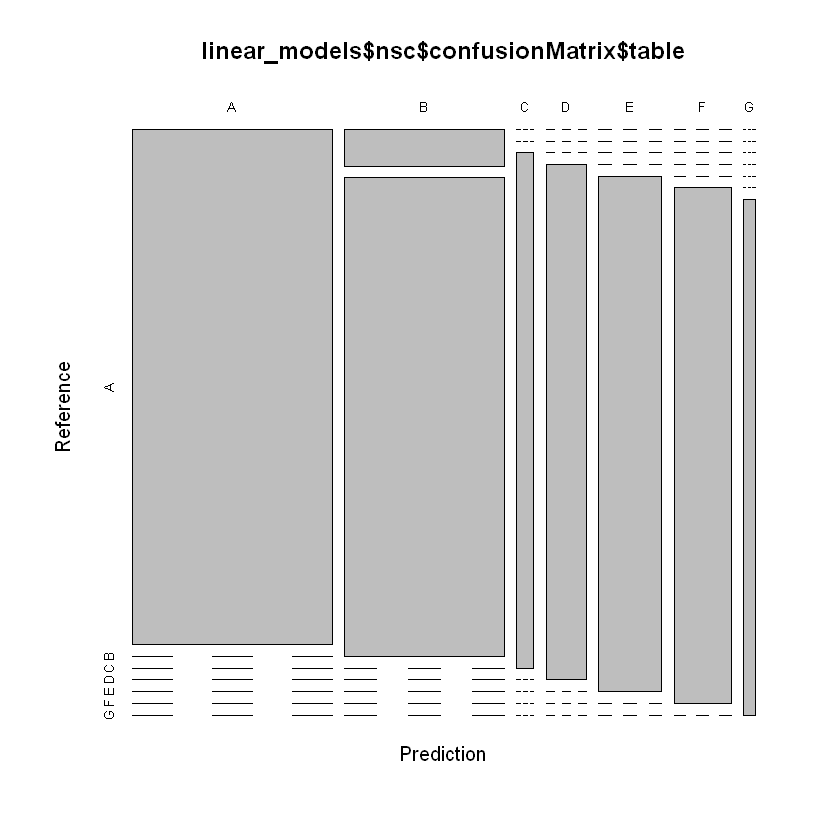

In [245]:
library(vcd)
mosaicplot( linear_models$nsc$confusionMatrix $table)

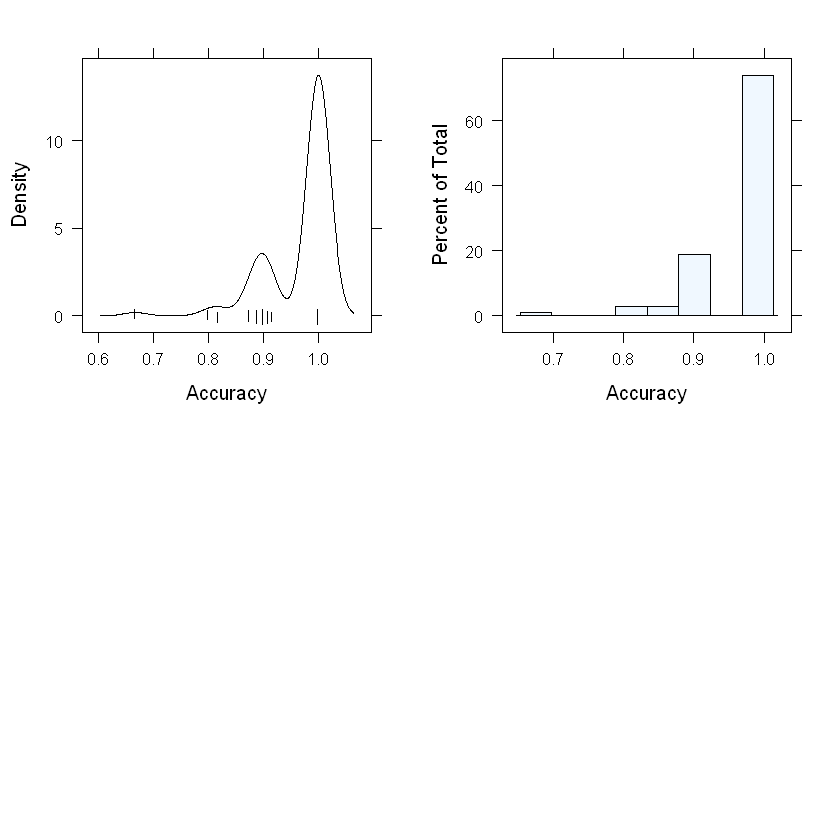

In [248]:
trellis.par.set(caretTheme())
p1 <- densityplot(linear_models$nsc$classifier, pch = "|")
p2 <- histogram(linear_models$nsc$classifier)

grid.arrange(p1,p2,ncol=2,nrow=2)

12.3. The web site for the MLC++ software package contains a number of machine learning data sets. The “churn” data set was developed to  redict
telecom customer churn based on information about their account. The data files state that the data are “artificial based on claims similar to real world.” The data consist of 19 predictors related to the customer account, such as the number of customer service calls, the area code, and the number of minutes. The outcome is whether the customer churned.
The data are contained in the C50 package and can be loaded using:
```r
> library(C50)
> data(churn)
> ## Two objects are loaded: churnTrain and churnTest
> str(churnTrain)
> table(churnTrain$Class)
```
- (a) Explore the data by visualizing the relationship between the predictors and the outcome. Are there important features of the predictor data themselves, such as between-predictor correlations or degenerate distributions? Can functions of more than one predictor be used to model the data more effectively?
- (b) Fit some basic models to the training set and tune them via resampling. What criteria should be used to evaluate the effectiveness of the models?
- (c) Use lift charts to compare models. If you wanted to identify 80 % of the churning customers, how many other customers would also be identified?

In [106]:
library(C50)
data(churn)
str(churnTrain)

'data.frame':	3333 obs. of  20 variables:
 $ state                        : Factor w/ 51 levels "AK","AL","AR",..: 17 36 32 36 37 2 20 25 19 50 ...
 $ account_length               : int  128 107 137 84 75 118 121 147 117 141 ...
 $ area_code                    : Factor w/ 3 levels "area_code_408",..: 2 2 2 1 2 3 3 2 1 2 ...
 $ international_plan           : Factor w/ 2 levels "no","yes": 1 1 1 2 2 2 1 2 1 2 ...
 $ voice_mail_plan              : Factor w/ 2 levels "no","yes": 2 2 1 1 1 1 2 1 1 2 ...
 $ number_vmail_messages        : int  25 26 0 0 0 0 24 0 0 37 ...
 $ total_day_minutes            : num  265 162 243 299 167 ...
 $ total_day_calls              : int  110 123 114 71 113 98 88 79 97 84 ...
 $ total_day_charge             : num  45.1 27.5 41.4 50.9 28.3 ...
 $ total_eve_minutes            : num  197.4 195.5 121.2 61.9 148.3 ...
 $ total_eve_calls              : int  99 103 110 88 122 101 108 94 80 111 ...
 $ total_eve_charge             : num  16.78 16.62 10.3 5.26 12.61 ...

In [2]:
table(churnTrain$churn)


 yes   no 
 483 2850 

\begin{remark}
(a) Explore the data by visualizing the relationship between the predictors and the outcome. Are there important features of the predictor data themselves, such as between-predictor correlations or degenerate distributions? Can functions of more than one predictor be used to model the data more effectively?
\end{remark}


In [2]:
head(churnTrain)

state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,no


In [10]:
library(plyr)
state_info <- ddply(churnTrain,.(state,churn),summarize,
                  value=length(churn))
library(reshape2)
state_info <- dcast(state~churn,data=state_info)
state_info$churn_rate <- state_info$yes/(state_info$yes+state_info$no)
head(state_info[order(state_info$churn_rate,decreasing = T),])

,state,yes,no,churn_rate
5,CA,9,25,0.2647059
32,NJ,18,50,0.2647059
44,TX,18,54,0.2500000
21,MD,17,53,0.2428571
41,SC,14,46,0.2333333
23,MI,16,57,0.2191781


In [77]:
dcast(churnTrain, international_plan ~ churn)
dcast(churnTrain, voice_mail_plan ~ churn)

Using churn as value column: use value.var to override.
Aggregation function missing: defaulting to length


international_plan,yes,no
no,346,2664
yes,137,186


Using churn as value column: use value.var to override.
Aggregation function missing: defaulting to length


voice_mail_plan,yes,no
no,403,2008
yes,80,842


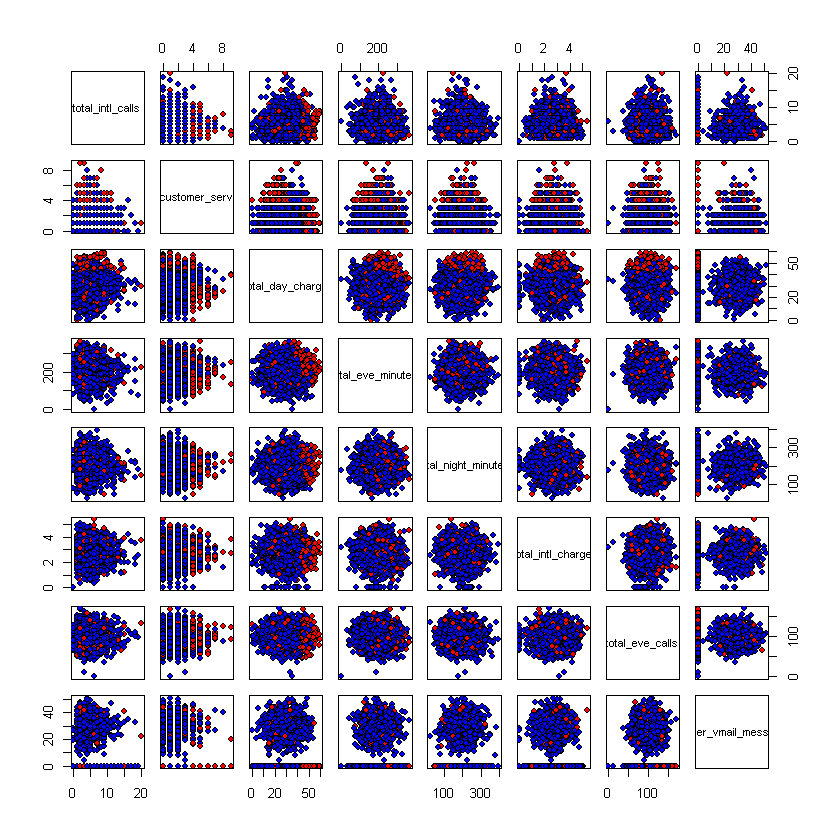

In [88]:
random_col <- sample(x = c(2,6:19),size=8)
pairs(churnTrain[,random_col], pch = 21,bg = c("red", "blue")[unclass(churnTrain$churn)])

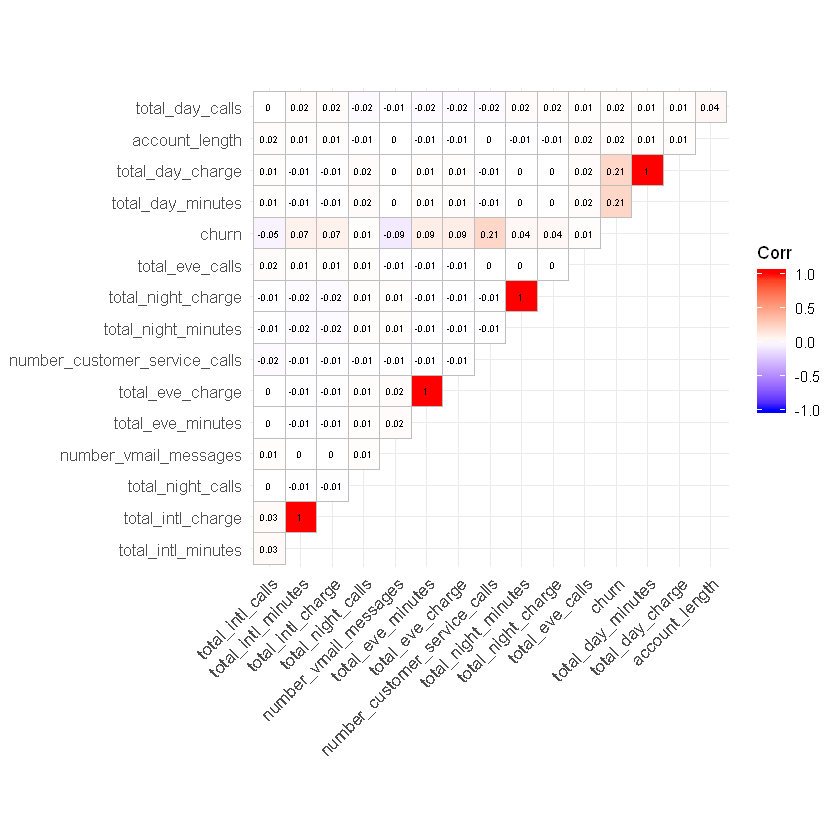

In [94]:
plt_data <- churnTrain[,c(2,6:20)]
plt_data$churn <- ifelse(plt_data$churn=="yes",1,0)
library(ggcorrplot)
ggcorrplot(round(cor(plt_data),2), hc.order = TRUE, type = "upper", lab = TRUE,lab_size = 2,tl.cex = 10)

\begin{remark}
- (b) Fit some basic models to the training set and tune them via resampling. What criteria should be used to evaluate the effectiveness of the models?
\end{remark}


In [107]:
#preProcess
any(is.null(churnTrain))

[1] FALSE

In [108]:
library(caret)
nearZeroVar(churnTrain,names=T)
churnTrain_flt <- churnTrain[,-nearZeroVar(churnTrain)]

[1] "number_vmail_messages"

In [115]:
findLinearCombos(churnTrain_flt[,c(2,6:18)])

$linearCombos
list()

$remove
NULL

In [126]:
colnames(churnTrain_flt[,c(2,6:18)])[findCorrelation(cor(churnTrain_flt[,c(2,6:18)]))]
churnTrain_flt <- subset(churnTrain_flt,select=-c(total_intl_charge,total_day_charge))

[1] "total_intl_charge"   "total_night_minutes" "total_eve_minutes"  
[4] "total_day_charge"

In [128]:
head(churnTrain_flt)

state,account_length,area_code,international_plan,voice_mail_plan,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
KS,128,area_code_415,no,yes,265.1,110,197.4,99,16.78,244.7,91,11.01,10.0,3,1,no
OH,107,area_code_415,no,yes,161.6,123,195.5,103,16.62,254.4,103,11.45,13.7,3,1,no
NJ,137,area_code_415,no,no,243.4,114,121.2,110,10.30,162.6,104,7.32,12.2,5,0,no
OH,84,area_code_408,yes,no,299.4,71,61.9,88,5.26,196.9,89,8.86,6.6,7,2,no
OK,75,area_code_415,yes,no,166.7,113,148.3,122,12.61,186.9,121,8.41,10.1,3,3,no
AL,118,area_code_510,yes,no,223.4,98,220.6,101,18.75,203.9,118,9.18,6.3,6,0,no


In [131]:
dim(churnTrain_flt)

[1] 3333   17

In [132]:
ctrl <- trainControl(summaryFunction = twoClassSummary,classProbs = T,
                    savePredictions=T,method="repeatedcv",number=10,repeats=10)
set.seed(456)
fit_lr <- train(churnTrain_flt[,1:16],churnTrain_flt$churn,method="glm",trControl = ctrl)
fit_lr

Warning message in train.default(churnTrain_flt[, 1:16], churnTrain_flt$churn, method = "glm", :
"The metric "Accuracy" was not in the result set. ROC will be used instead."

Generalized Linear Model 

3333 samples
  16 predictor
   2 classes: 'yes', 'no' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 3000, 3000, 3000, 3000, 3000, 2999, ... 
Resampling results:

  ROC        Sens       Spec     
  0.8055738  0.2333291  0.9652632


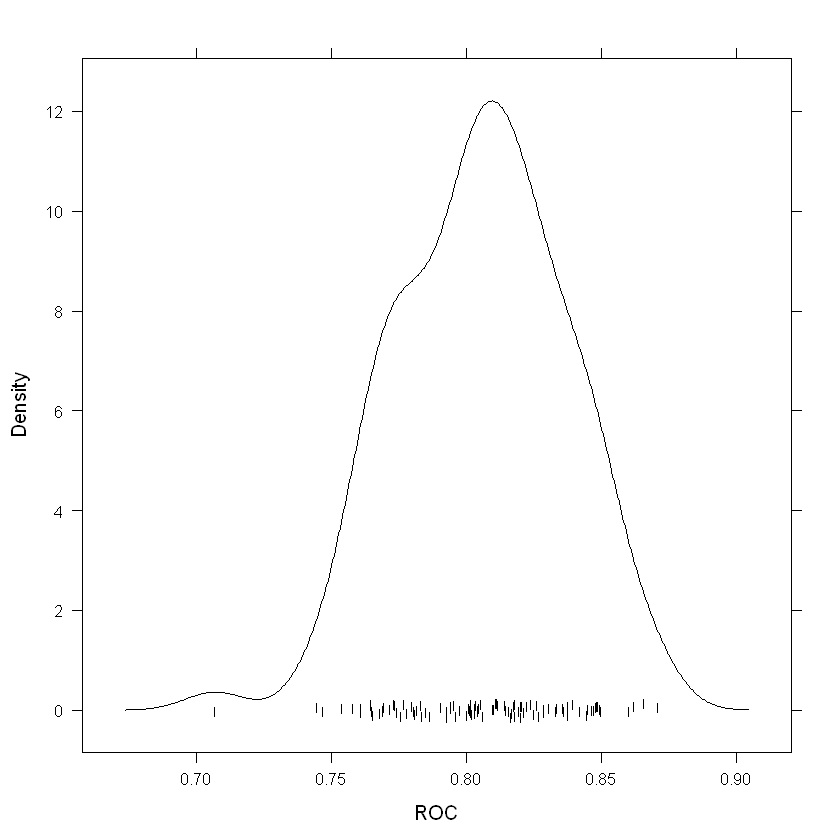

In [135]:
trellis.par.set(caretTheme())
densityplot(fit_lr, pch = "|")

In [137]:
confusionMatrix(reference = churnTrain_flt$churn,data = predict(fit_lr,newdata = churnTrain_flt[,1:16]) )

Confusion Matrix and Statistics

          Reference
Prediction  yes   no
       yes  126   85
       no   357 2765
                                          
               Accuracy : 0.8674          
                 95% CI : (0.8554, 0.8787)
    No Information Rate : 0.8551          
    P-Value [Acc > NIR] : 0.02217         
                                          
                  Kappa : 0.3016          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.26087         
            Specificity : 0.97018         
         Pos Pred Value : 0.59716         
         Neg Pred Value : 0.88565         
             Prevalence : 0.14491         
         Detection Rate : 0.03780         
   Detection Prevalence : 0.06331         
      Balanced Accuracy : 0.61552         
                                          
       'Positive' Class : yes             
                                          

In [143]:
churnTest_flt <- churnTest[,colnames(churnTest) %in% colnames(churnTrain_flt)]
confusionMatrix(reference = churnTest_flt$churn,data = predict(fit_lr,newdata = churnTest_flt[,1:16]) )

Confusion Matrix and Statistics

          Reference
Prediction  yes   no
       yes   55   45
       no   169 1398
                                          
               Accuracy : 0.8716          
                 95% CI : (0.8546, 0.8873)
    No Information Rate : 0.8656          
    P-Value [Acc > NIR] : 0.249           
                                          
                  Kappa : 0.2798          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.24554         
            Specificity : 0.96881         
         Pos Pred Value : 0.55000         
         Neg Pred Value : 0.89215         
             Prevalence : 0.13437         
         Detection Rate : 0.03299         
   Detection Prevalence : 0.05999         
      Balanced Accuracy : 0.60718         
                                          
       'Positive' Class : yes             
                                          

In [144]:
predict(fit_lr,newdata = churnTest_flt[,1:16],type="prob")

yes,no
0.027152291,0.9728477
0.126052513,0.8739475
0.205659152,0.7943408
0.098498934,0.9015011
0.148331912,0.8516681
0.032226136,0.9677739
0.046521246,0.9534788
0.044573543,0.9554265
0.016378378,0.9836216
0.035480894,0.9645191


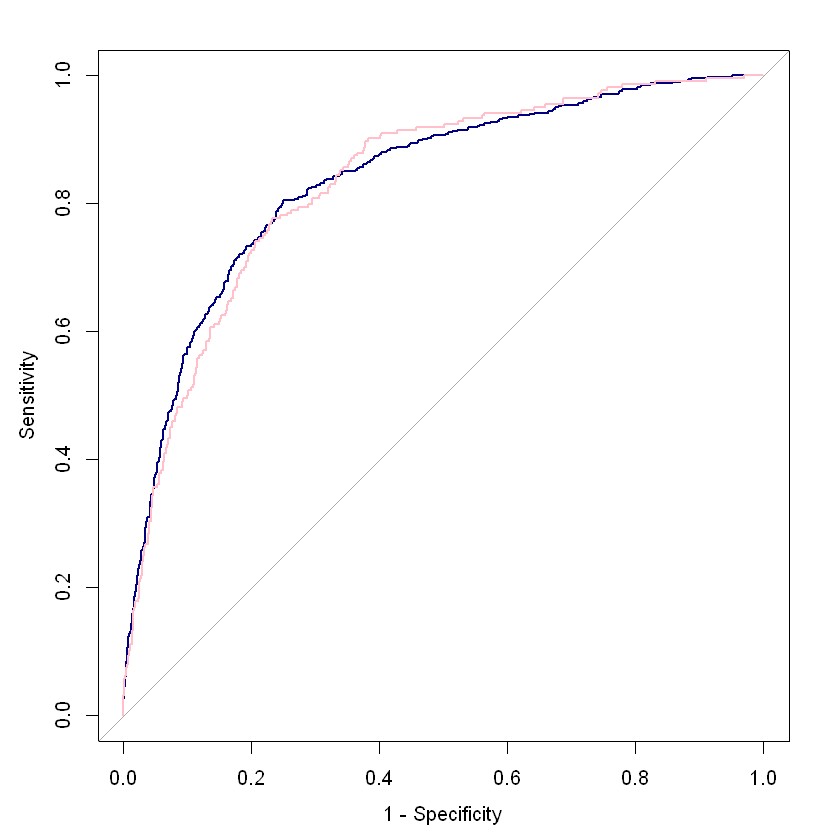

In [150]:
library(pROC)
pred_trn <- predict(fit_lr,newdata = churnTrain_flt[,1:16],type="prob")
roc_lr_trn <- pROC::roc(response=churnTrain_flt$churn,predictor=pred_trn[,1],levels=rev(levels(churnTrain_flt$churn)))

pred_vld <- predict(fit_lr,newdata = churnTest_flt[,1:16],type="prob")
roc_lr_vld <- pROC::roc(response=churnTest_flt$churn,predictor=pred_vld[,1],levels=rev(levels(churnTest_flt$churn)))

plot( roc_lr_trn, legacy.axes=T, add=F, col="navy")
plot( roc_lr_vld, legacy.axes=T, add=T, col="pink" )

\begin{remark}
(c) Use lift charts to compare models. If you wanted to identify 80 % of the churning customers, how many other customers would also be identified?
\end{remark}


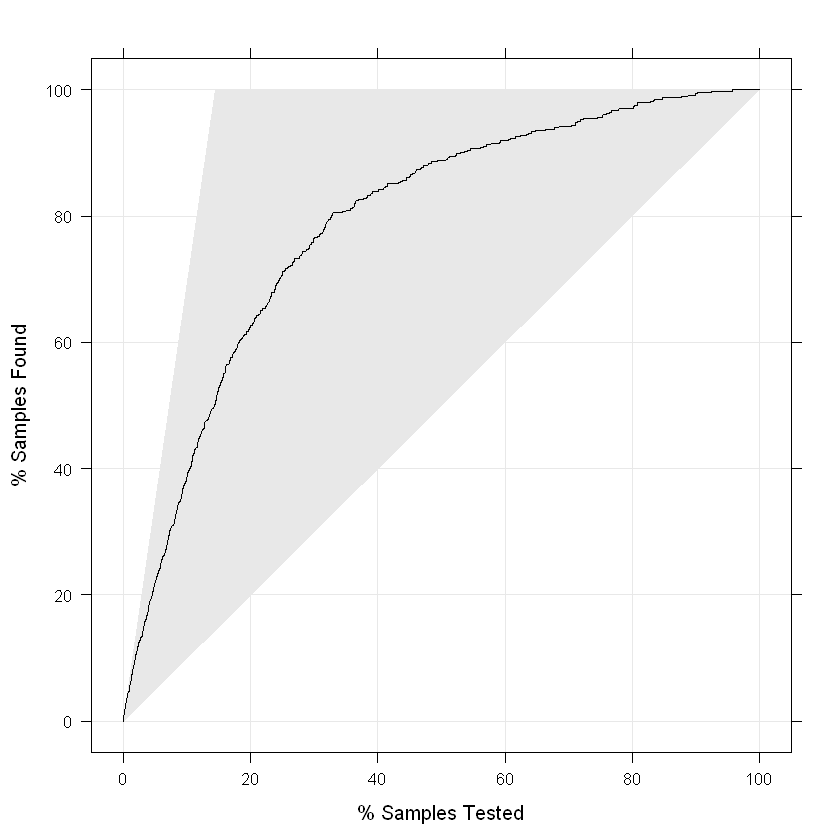

In [164]:
lift_trn <- lift(churnTrain_flt$churn~pred_trn[,1])
plot(lift_trn,grid = T)

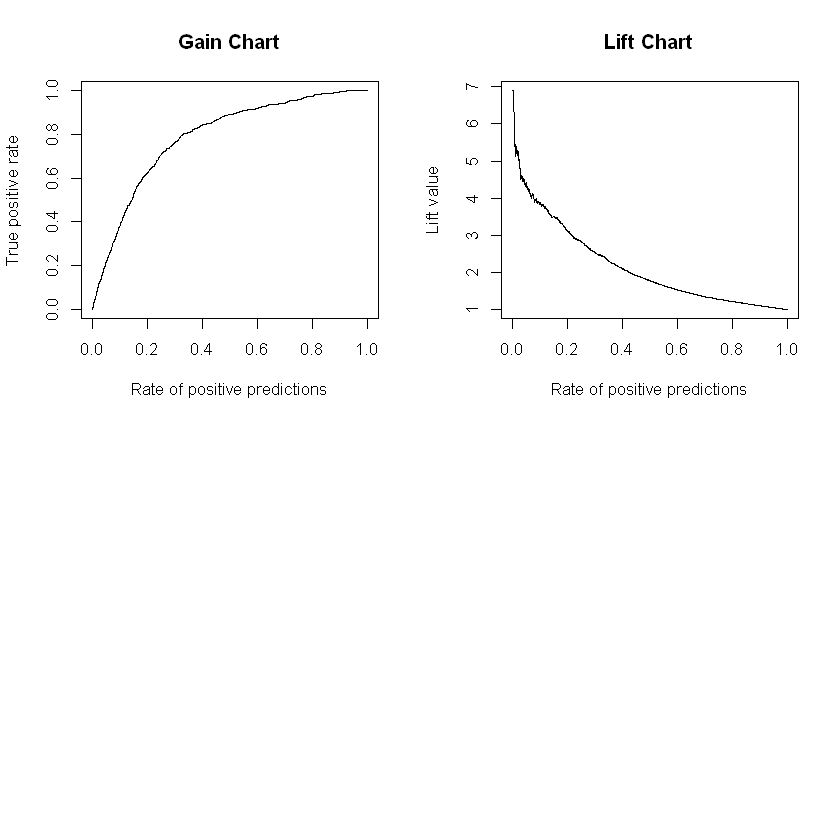

In [166]:
require(ROCR)
pred <- prediction(predictions = pred_trn[,1],labels = churnTrain_flt$churn )
par(mfrow = c(2, 2))
gain <- performance(pred, "tpr", "rpp")
plot(gain, main = "Gain Chart")
lift <- performance(pred, "lift", "rpp")
plot(lift, main = "Lift Chart")

---
&#x1F37A; `Drunk Coding`